# Random forest su dati epigenomici

In [1]:
import nbimporter
from Import_data import get_df_class, get_df_epigenomic, get_df_sequence , get_type_of_nucl_from_list_of_sequence, convertToNum
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

sns.set(color_codes=True)

# RandomForest
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

#BO
from GPyOpt.methods import BayesianOptimization
from numpy.random import seed

#https://stackoverflow.com/questions/51480776/how-to-implement-ratio-based-smote-oversampling-while-cv-ing-dataset
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

#path
path_relazione = '../../relazione/img/'
path_output = '../output/'

%matplotlib inline

random_state = 42
seed(random_state)
problem = ['A-E','I-E']
line = 'GM12878'

Importing Jupyter notebook from Import_data.ipynb


Using TensorFlow backend.


/home/lucavecchi/uni/bioinfo/progetto/venv/lib64/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Parameters
problem = ["A-P", "I-P"]
line = "GM12878"


In [3]:
cell_line = line
path_c = f'../data/classes/{cell_line}_class.csv'
path_e = f'../data/epigenomic-data/{cell_line}.csv'
path_s = f'../data/sequences/{cell_line}.fa'

df_c = get_df_class(path_c)
df_e = get_df_epigenomic(path_e)
df_s = get_df_sequence(path_s)

problem_slug = "_vs_".join(problem)
problem_slug

'A-P_vs_I-P'

In [4]:
df_e.head()

ATF2  ATF3   BATF  BCL11A   BCL3  BCLAF1  BHLHE40  BRCA1  C-FOS(FOS)  \
0  7.46  3.67  16.20   20.02  28.27    9.01    13.74   2.31        2.39   
1  3.07  3.54   1.17    1.06   6.44    2.67     9.22   1.70        0.22   
2  3.45  0.86   2.21    3.46   4.35    2.10    22.07   1.63        0.87   
3  8.03  1.77   3.75    4.51   8.54    4.00    19.74   2.55        0.15   
4  2.89  1.15   1.06    2.39   4.21    3.64     7.43   2.32        0.69   

   C-MYC(MYC)  ...  USF1   USF2  WHIP(WRNIP1)   YY1  ZBTB33   ZEB1  ZNF143  \
0        6.30  ...  4.21   4.94          2.11  0.00    3.82  24.44    3.45   
1        8.30  ...  3.01   3.33          1.31  0.00    0.27   4.47    2.64   
2        8.65  ...  4.16  11.26          3.91  0.09    2.01   7.15    1.64   
3        3.25  ...  1.59   2.63          3.34  0.00    2.01   3.69    0.76   
4        5.45  ...  2.12   5.33          3.83  0.00    0.83   9.19    1.04   

   ZNF274  ZNF384  ZZZ3  
0    0.10    3.62  0.15  
1    0.02    1.01  0.00  
2    0.00    1.43  0.10  
3    0.00    7.21  0.00  
4    0.00    4.10  0.04  

[5 rows x 101 columns]

In [5]:
# conversione etichette one_hot (si potrebbe fare anche singolo)
type_of_class = sorted(list(df_c['class'].unique()))
lab2int = convertToNum(type_of_class)
classes = np.asarray([  lab2int(el) for el in df_c["class"].values])
print(type_of_class)
classes

['A-E', 'A-P', 'A-X', 'I-E', 'I-P', 'I-X', 'UK']


array([0, 0, 0, ..., 6, 6, 6])

In [6]:
int_labels = [lab2int(el) for el in problem]
int_labels, problem

([1, 4], ['A-P', 'I-P'])

In [7]:
#selezione del problema
X = df_e.values
y = classes
mask = [ el in int_labels for el in classes ]
X,y = X[mask],y[mask]
set(y), len(y)

({1, 4}, 84707)

In [8]:
def _create01mapping(elements):
    d = { k:v for v,k in enumerate(elements)}
    return lambda x : d[x]

label_mapping = _create01mapping(set(y))
y = np.array([ label_mapping(el) for el in y])

# TP è sempre la classe meno numerosa, è il soggetto di interesse
sum(y == 0),len(y==1)
if sum(y==0) < len(y)/2:
    y = 1-y #flipping
y

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
#correct the dimension
X = np.array([ el for el in X])
X.shape

(84707, 101)

In [10]:
randSampler = SMOTE(random_state=random_state)

def resampler(x,y):
    # https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
    x, y = randSampler.fit_resample(x, y)
    return x,y


## Cerchiamo un intorno di attributi buoni

In [11]:
n_split = 3

def happy_function(x):
    criterion, n_estimators, max_depth, max_features = x[0]
    criterion = 'gini' if criterion==1 else 'entropy'
    

    
    conf_matrix = np.zeros([2,2])
    
    skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
    for nth, other in enumerate(skf.split(X,y)):
        train_index, test_index = other
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train_balanced, y_train_balanced = resampler(X_train, y_train)

        rf = RandomForestClassifier(max_features=int(max_features),max_depth=int(max_depth),n_estimators=int(n_estimators),criterion=criterion, random_state = random_state)
        rf.fit(X_train,y_train)

        y_pred = rf.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix = conf_matrix + cm
        
    conf_matrix = conf_matrix.astype(int)
    #print(conf_matrix)
    TN, FP, FN, TP = conf_matrix.flatten()
    
    precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
    recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
    f1_score = 2* (precision*recall)/(precision + recall)
    f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
    accuracy = (TP + TN )/(TP + TN + FP + FN)
    print(f'End with: criterion:{criterion} n_estim:{n_estimators} max_depth:{max_depth} max_feat:{max_features}    (Acc,prec,rec,f1)=({accuracy:.3f},{precision:.3f},{recall:.3f},{f1_score:.3f})')
    return f1_score
    

In [12]:
batch_size = 4
num_cores = 4
max_time = 60*40
max_iter = 50
init_points = 40

domain = [
    {'name': 'criterion', 'type': 'categorical', 'domain':(0,1)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain':list(range(1,201,2))},
    {'name': 'max_depth','type': 'discrete', 'domain': list(range(1,int(math.log2(X.shape[0]))*3,1)) },
    {'name': 'max_features', 'type': 'discrete', 'domain':list(range(1,int(X.shape[1]/2),1)) }
]

In [13]:
myBopt = BayesianOptimization(f=happy_function,
                            domain = domain,
                            maximize=True,
                            normalize_Y = False,
                            model_type="GP",
                            acquisition_type = 'EI',
                            acquisition_jitter= 0.03,#"GP_MCMC",
                            #acquisition_type = "EI",#'EI_MCMC',
                            #evaluator_type = 'predictive',   
                            initial_design_numdata = init_points,
                            batch_size = batch_size,
                            num_cores = num_cores)

myBopt.run_optimization(max_iter=max_iter,max_time=max_time, save_models_parameters=False, verbosity=True)

End with: criterion:entropy n_estim:183.0 max_depth:2.0 max_feat:11.0    (Acc,prec,rec,f1)=(0.988,0.972,0.934,0.953)


End with: criterion:gini n_estim:83.0 max_depth:4.0 max_feat:24.0    (Acc,prec,rec,f1)=(0.990,0.970,0.953,0.962)


End with: criterion:entropy n_estim:117.0 max_depth:40.0 max_feat:8.0    (Acc,prec,rec,f1)=(0.991,0.971,0.961,0.966)


End with: criterion:entropy n_estim:119.0 max_depth:6.0 max_feat:17.0    (Acc,prec,rec,f1)=(0.991,0.971,0.961,0.966)


End with: criterion:gini n_estim:29.0 max_depth:4.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.990,0.969,0.954,0.962)


End with: criterion:entropy n_estim:159.0 max_depth:42.0 max_feat:8.0    (Acc,prec,rec,f1)=(0.991,0.971,0.962,0.966)


End with: criterion:entropy n_estim:93.0 max_depth:26.0 max_feat:5.0    (Acc,prec,rec,f1)=(0.991,0.970,0.958,0.964)


End with: criterion:entropy n_estim:123.0 max_depth:29.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.992,0.970,0.968,0.969)


End with: criterion:entropy n_estim:123.0 max_depth:18.0 max_feat:33.0    (Acc,prec,rec,f1)=(0.992,0.971,0.968,0.969)


End with: criterion:entropy n_estim:127.0 max_depth:36.0 max_feat:28.0    (Acc,prec,rec,f1)=(0.992,0.970,0.968,0.969)


End with: criterion:gini n_estim:41.0 max_depth:8.0 max_feat:12.0    (Acc,prec,rec,f1)=(0.991,0.972,0.960,0.966)


End with: criterion:entropy n_estim:101.0 max_depth:34.0 max_feat:39.0    (Acc,prec,rec,f1)=(0.992,0.970,0.967,0.969)


End with: criterion:gini n_estim:7.0 max_depth:21.0 max_feat:23.0    (Acc,prec,rec,f1)=(0.991,0.967,0.963,0.965)


End with: criterion:entropy n_estim:109.0 max_depth:10.0 max_feat:41.0    (Acc,prec,rec,f1)=(0.992,0.969,0.967,0.968)


End with: criterion:entropy n_estim:13.0 max_depth:15.0 max_feat:8.0    (Acc,prec,rec,f1)=(0.991,0.970,0.957,0.963)


End with: criterion:gini n_estim:101.0 max_depth:31.0 max_feat:9.0    (Acc,prec,rec,f1)=(0.992,0.972,0.963,0.967)


End with: criterion:gini n_estim:17.0 max_depth:47.0 max_feat:44.0    (Acc,prec,rec,f1)=(0.991,0.968,0.964,0.966)


End with: criterion:entropy n_estim:35.0 max_depth:40.0 max_feat:48.0    (Acc,prec,rec,f1)=(0.992,0.970,0.967,0.969)


End with: criterion:gini n_estim:123.0 max_depth:44.0 max_feat:42.0    (Acc,prec,rec,f1)=(0.992,0.971,0.966,0.968)


End with: criterion:entropy n_estim:5.0 max_depth:14.0 max_feat:7.0    (Acc,prec,rec,f1)=(0.989,0.960,0.957,0.958)


End with: criterion:gini n_estim:27.0 max_depth:18.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.992,0.970,0.965,0.968)


End with: criterion:gini n_estim:3.0 max_depth:25.0 max_feat:27.0    (Acc,prec,rec,f1)=(0.990,0.961,0.957,0.959)


End with: criterion:gini n_estim:77.0 max_depth:23.0 max_feat:33.0    (Acc,prec,rec,f1)=(0.992,0.971,0.966,0.969)


End with: criterion:entropy n_estim:141.0 max_depth:15.0 max_feat:37.0    (Acc,prec,rec,f1)=(0.992,0.970,0.968,0.969)


End with: criterion:gini n_estim:145.0 max_depth:14.0 max_feat:34.0    (Acc,prec,rec,f1)=(0.992,0.971,0.966,0.968)


End with: criterion:entropy n_estim:69.0 max_depth:7.0 max_feat:1.0    (Acc,prec,rec,f1)=(0.985,0.958,0.922,0.940)


End with: criterion:gini n_estim:167.0 max_depth:45.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.992,0.971,0.966,0.968)


End with: criterion:entropy n_estim:99.0 max_depth:44.0 max_feat:39.0    (Acc,prec,rec,f1)=(0.992,0.969,0.967,0.968)


End with: criterion:entropy n_estim:177.0 max_depth:16.0 max_feat:24.0    (Acc,prec,rec,f1)=(0.992,0.971,0.967,0.969)


End with: criterion:gini n_estim:119.0 max_depth:45.0 max_feat:37.0    (Acc,prec,rec,f1)=(0.992,0.971,0.966,0.968)


End with: criterion:gini n_estim:105.0 max_depth:26.0 max_feat:22.0    (Acc,prec,rec,f1)=(0.992,0.970,0.965,0.968)


End with: criterion:gini n_estim:87.0 max_depth:45.0 max_feat:47.0    (Acc,prec,rec,f1)=(0.992,0.970,0.966,0.968)


End with: criterion:gini n_estim:155.0 max_depth:9.0 max_feat:5.0    (Acc,prec,rec,f1)=(0.990,0.971,0.953,0.962)


End with: criterion:entropy n_estim:119.0 max_depth:29.0 max_feat:35.0    (Acc,prec,rec,f1)=(0.992,0.969,0.968,0.969)


End with: criterion:gini n_estim:93.0 max_depth:25.0 max_feat:3.0    (Acc,prec,rec,f1)=(0.990,0.969,0.953,0.961)


End with: criterion:entropy n_estim:71.0 max_depth:1.0 max_feat:14.0    (Acc,prec,rec,f1)=(0.988,0.970,0.935,0.953)


End with: criterion:gini n_estim:179.0 max_depth:24.0 max_feat:40.0    (Acc,prec,rec,f1)=(0.992,0.971,0.966,0.968)


End with: criterion:gini n_estim:183.0 max_depth:41.0 max_feat:1.0    (Acc,prec,rec,f1)=(0.988,0.962,0.943,0.952)


End with: criterion:gini n_estim:15.0 max_depth:1.0 max_feat:14.0    (Acc,prec,rec,f1)=(0.985,0.968,0.909,0.938)


End with: criterion:entropy n_estim:161.0 max_depth:24.0 max_feat:26.0    (Acc,prec,rec,f1)=(0.992,0.971,0.967,0.969)


End with: criterion:entropy n_estim:15.0 max_depth:47.0 max_feat:1.0    (Acc,prec,rec,f1)=(0.987,0.959,0.942,0.950)


num acquisition: 1, time elapsed: 41.06s


End with: criterion:gini n_estim:185.0 max_depth:47.0 max_feat:46.0    (Acc,prec,rec,f1)=(0.992,0.970,0.966,0.968)


num acquisition: 2, time elapsed: 1581.33s


End with: criterion:entropy n_estim:199.0 max_depth:35.0 max_feat:49.0    (Acc,prec,rec,f1)=(0.992,0.970,0.968,0.969)


num acquisition: 3, time elapsed: 2321.80s


End with: criterion:gini n_estim:175.0 max_depth:47.0 max_feat:49.0    (Acc,prec,rec,f1)=(0.992,0.970,0.966,0.968)


num acquisition: 4, time elapsed: 3886.01s


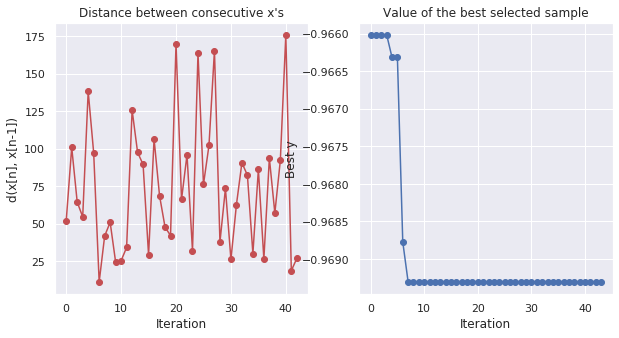

In [14]:
myBopt.plot_convergence(filename="prova.pdf")

In [15]:
def get_grid_random_forest(m_from_opt, num_el):
    criterion, n_estimators, max_depth, max_features = m_from_opt.x_opt
    r = [ 2**el for el in range(1,num_el+1)]
    r.extend([-el for el in r]),r.append(0)
    r= sorted(r)
    r = np.array(r)

    return { 'rf__max_depth': [ el for el in r + int(max_depth) if el > 0 ],
     'rf__max_features': [ el for el in r + int(max_features) if el > 0 ],
      'rf__n_estimators': [ el for el in r + int(n_estimators) if el > 0],
     'rf__criterion': ('gini',) if criterion >0.5 else ('entropy',) }


In [16]:
grid_values = get_grid_random_forest(myBopt,1)
grid_values

{'rf__max_depth': [16, 18, 20],
 'rf__max_features': [31, 33, 35],
 'rf__n_estimators': [121, 123, 125],
 'rf__criterion': ('entropy',)}

In [17]:
#define some scorer for gridsearch
def accuracy_on_true_pred(y_true,y_pred, **kwargs):
    acc = np.sum(y_true==y_pred)/len(y_true)
    print(f'Acc: {acc}')
    return acc

def f1_score_on_true_pred(y_true, y_pred, **kwargs):
    TN, FP, FN, TP  = confusion_matrix(y_true, y_pred).astype(int).flatten()

    #caso quando tp + fp o fn + tp sono 0 
    precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
    recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
    f1_score = 2* (precision*recall)/(precision + recall)
    f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
    return f1_score

accuracy_scorer = make_scorer(accuracy_on_true_pred, greater_is_better=True, needs_proba=False,needs_threshold=False)
f1_scorer = make_scorer(f1_score_on_true_pred, greater_is_better=True, needs_proba=False, needs_threshold=False)

In [18]:
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline([
    ('oversampling',RandomOverSampler(random_state=random_state))
    ,('rf',rf)
])

clf = GridSearchCV(pipeline
                   ,grid_values
                   ,scoring = f1_scorer
                   ,cv = 4
                   ,n_jobs=-1
                   ,pre_dispatch='3*n_jobs'
                   ,verbose=2)
clf.fit(X,y)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 50.7min


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 179.0min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('oversampling',
                                        RandomOverSampler(random_state=42,
                                                          ratio=None,
                                                          return_indices=False,
                                                          sampling_strategy='auto')),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
 

In [19]:
df_result = pd.DataFrame(clf.cv_results_)
df_result = df_result.sort_values(['rank_test_score','std_test_score'],ascending=[1,1])
df_result.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
22     388.467385      7.521607         0.423596        0.044387   
21     382.554174      4.897776         0.498558        0.079650   
23     393.512976      7.185009         0.484241        0.060393   
8      414.943505      8.777255         0.569687        0.070060   
7      406.853886      7.063399         0.459145        0.066176   

   param_rf__criterion param_rf__max_depth param_rf__max_features  \
22             entropy                  20                     33   
21             entropy                  20                     33   
23             entropy                  20                     33   
8              entropy                  16                     35   
7              entropy                  16                     35   

   param_rf__n_estimators                                             params  \
22                    123  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
21                    121  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
23                    125  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
8                     125  {'rf__criterion': 'entropy', 'rf__max_depth': ...   
7                     123  {'rf__criterion': 'entropy', 'rf__max_depth': ...   

    split0_test_score  split1_test_score  split2_test_score  \
22           0.973373           0.963192           0.972684   
21           0.973193           0.963017           0.972684   
23           0.973013           0.963017           0.972684   
8            0.973373           0.961426           0.973033   
7            0.973193           0.961615           0.972653   

    split3_test_score  mean_test_score  std_test_score  rank_test_score  
22           0.968785         0.969508        0.004044                1  
21           0.968785         0.969420        0.004071                2  
23           0.968796         0.969377        0.004029                3  
8            0.968113         0.968986        0.004836                4  
7            0.968113         0.968894        0.004642                5

## Analisi migliore classificatore trovato ROC & PRC

In [20]:
np.save(f'{path_output}{cell_line}_{problem_slug}_best_param_rf_epi',df_result.iloc[0].to_dict())
# recover if there are some problem https://stackoverflow.com/questions/8361561/recover-dict-from-0-d-numpy-array
#df_best_result = np.load(f'{path_output}{cell_line}_{problem_slug}_best_param_rf.npy', allow_pickle=True)
#df_best_result = df_best_result.item()

Salvataggio miglior modello

In [21]:
df_best_result = df_result.iloc[0].to_dict()

## Statistiche

In [22]:
from joblib import dump, load


conf_matrix = np.zeros([2,2])
    
skf = StratifiedKFold(n_splits=n_split, random_state=random_state)
for nth, other in enumerate(skf.split(X,y)):
    train_index, test_index = other
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_balanced, y_train_balanced = resampler(X_train, y_train)

    best_rf = RandomForestClassifier(max_depth=df_best_result['param_rf__max_depth'],criterion=df_best_result['param_rf__criterion'], max_features=df_best_result['param_rf__max_features'], n_estimators=df_best_result['param_rf__n_estimators'])
    best_rf.fit(X_train,y_train)

    y_pred = best_rf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = conf_matrix + cm

conf_matrix = conf_matrix.astype(int)
#print(conf_matrix)
TN, FP, FN, TP = conf_matrix.flatten()

precision = TP / ( 0.00001 if TP + FP == 0 else TP + FP )
recall = TP / ( 0.00001 if TP + FN == 0 else TP + FN )
f1_score = 2* (precision*recall)/(precision + recall)
f1_score = f1_score if not (f1_score is np.nan or f1_score != f1_score) else 0
accuracy = (TP + TN )/(TP + TN + FP + FN)


#salvataggio o caricamento
dump(best_rf, f'{path_output}{cell_line}_{problem_slug}_rf_epi.joblib') 
#clf = load('filename.joblib') 
print(best_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=33, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=123,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


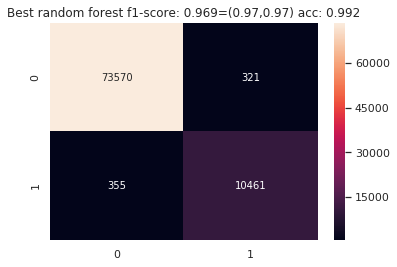

In [23]:
plotted = sns.heatmap(conf_matrix,annot=True,fmt="d").set_title(f'Best random forest f1-score: {f1_score:.3f}=({precision:.2f},{recall:.2f}) acc: {accuracy:.3f}')
fig = plotted.get_figure()
fig.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_confusion_rf_epi.pdf')

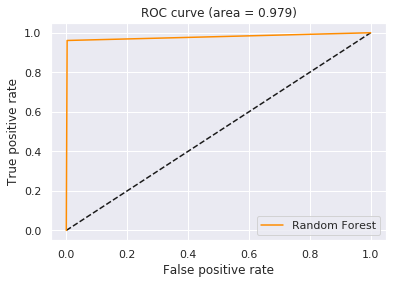

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
auc = roc_auc_score(y_test, y_pred)
false_positive, true_positive, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve (area = {auc:.3f})')
plt.legend(loc='best')
plt.savefig(path_relazione + f'{cell_line}_{problem_slug}_best_ROC_AUC_rf_epi.pdf')
plt.show()


## Salvataggio risultato medio migliore classificatore

In [25]:
dump({'accuracy':accuracy,
      'precision':precision,
      'recall':recall,
      'f1-score':f1_score,
      'conf_matrix': conf_matrix, 
      'report': classification_report(y_test,y_pred)
     },
     f'{path_output}{cell_line}_{problem_slug}_best_result_rf_epi.joblib') 

['../output/GM12878_A-P_vs_I-P_best_result_rf_epi.joblib']